In [1]:
using HTTP
using JSON
using DataFrames
using Dates
using TimeSeries

In [2]:
include("../env.jl")

"VVp9vMTjNvSEUqJJuqpRLw5r4oUq2uFGbX2VipCE"

In [3]:
function wgetStock(sym::String)
    fromTime =  Dates.format(now()-Day(500), "yyyy-mm-ddTHH:MM:SS")
    @show fromTime
    headers = ["APCA-API-KEY-ID" => ENV["APCA-API-KEY-ID"], "APCA-API-SECRET-KEY" => ENV["APCA-API-SECRET-KEY"] ]
    url_query = "https://data.alpaca.markets/v1/bars/day?symbols="*sym*"&after="*fromTime*"&limit=500"
    raw_response = HTTP.request("GET", url_query, headers)
    rsp = JSON.parse(String(raw_response.body))
    df2 = DataFrame(t = Int[],h = Float32[],l = Float32[],o = Float32[],c = Float32[],v = Float32[] )
    for (sym,v) in rsp
        for q in v
            push!(df2,q)
        end
    end
    transform!(df2, :t => ( x -> Dates.unix2datetime.(x) ) => :ondate)
    DataFrames.rename!(df2,:h => :High)
    DataFrames.rename!(df2,:l => :Low)
    DataFrames.rename!(df2,:o => :Open)
    DataFrames.rename!(df2,:c => :Close)
    DataFrames.rename!(df2,:v => :Volume)
    sort!(df2,order(:ondate))
    return select(df2,[:Open,:Close,:High,:Low,:Volume,:ondate])
end

wgetStock (generic function with 1 method)

In [4]:
tick1="GLD"
df1 = wgetStock(tick1)
tick2="IAU"
df2 = wgetStock(tick2)

fromTime = "2020-02-01T15:23:41"
fromTime = "2020-02-01T15:23:46"


,Open,Close,High,Low,Volume,ondate
,Float32,Float32,Float32,Float32,Float32,DateTime
1,12.93,12.88,12.96,12.82,2.32213e7,2019-06-18T04:00:00
2,12.86,12.965,12.98,12.32,2.38345e7,2019-06-19T04:00:00
3,13.22,13.295,13.34,12.405,2.45128e7,2019-06-20T04:00:00
4,13.37,13.39,13.405,13.29,1.66859e7,2019-06-21T04:00:00
5,13.47,13.58,13.59,13.44,2.22944e7,2019-06-24T04:00:00
6,13.69,13.61,13.75,12.86,5.52916e7,2019-06-25T04:00:00
7,13.5,13.48,13.55,13.43,1.58035e7,2019-06-26T04:00:00
8,13.43,13.48,13.49,13.41,1.53106e7,2019-06-27T04:00:00
9,13.49,13.505,13.53,13.45,8.48827e6,2019-06-28T04:00:00


In [5]:
using Pkg 
Pkg.add("StatsBase")
using StatsBase
Pkg.add("HypothesisTests")
using HypothesisTests

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [6]:

using Plots
function testStationary(df)
    y = autocor(df,1:20)
    display(bar(y))
    y = pacf(df,1:20)
    display(bar(y))
    ADFTest(df,:none,1)
end

testStationary (generic function with 1 method)

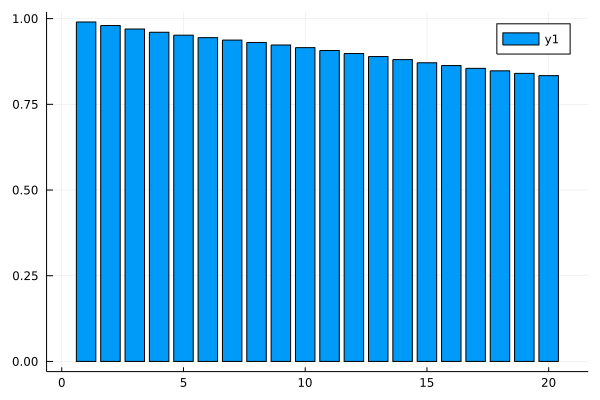

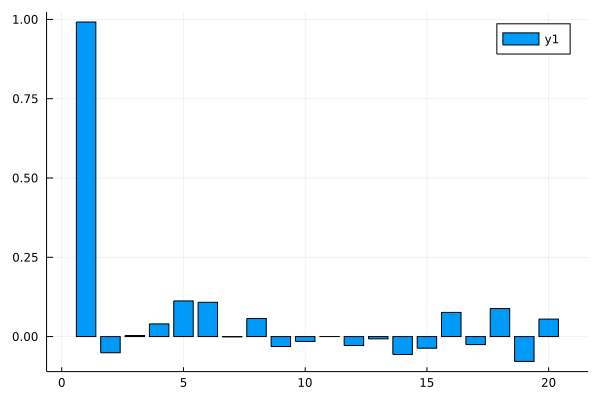

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.000423016

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.8971

Details:
    sample size in regression:          498
    number of lags:                     1
    ADF statistic:                      0.873297
    Critical values at 1%, 5%, and 10%: [-2.57023 -1.94155 -1.6163]


In [7]:
testStationary(df1[!,:Close])

In [8]:
Pkg.add("TimeSeries")
using TimeSeries

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [9]:
ta1 = TimeArray(df1;timestamp = :ondate)
ta2 = TimeArray(df2;timestamp = :ondate)
merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])

498×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-20T04:00:00 to 2021-06-14T04:00:00
│                     │ Close1 │ Close2 │
├─────────────────────┼────────┼────────┤
│ 2019-06-20T04:00:00 │ 131.12 │ 13.295 │
│ 2019-06-21T04:00:00 │ 132.0  │ 13.39  │
│ 2019-06-24T04:00:00 │ 133.94 │ 13.58  │
│ 2019-06-25T04:00:00 │ 134.2  │ 13.61  │
│ 2019-06-26T04:00:00 │ 132.97 │ 13.48  │
│ 2019-06-27T04:00:00 │ 132.84 │ 13.48  │
│ 2019-06-28T04:00:00 │ 133.17 │ 13.505 │
│ 2019-07-01T04:00:00 │ 130.6  │ 13.25  │
│ 2019-07-02T04:00:00 │ 133.38 │ 13.53  │
│ 2019-07-03T04:00:00 │ 133.64 │ 13.56  │
│ 2019-07-05T04:00:00 │ 132.16 │ 13.4   │
│ 2019-07-08T04:00:00 │ 131.29 │ 13.32  │
   ⋮
│ 2021-05-28T04:00:00 │ 178.31 │ 36.26  │
│ 2021-06-01T04:00:00 │ 177.93 │ 36.2   │
│ 2021-06-02T04:00:00 │ 178.75 │ 36.37  │
│ 2021-06-03T04:00:00 │ 175.25 │ 35.645 │
│ 2021-06-04T04:00:00 │ 177.17 │ 36.04  │
│ 2021-06-07T04:00:00 │ 177.88 │ 36.185 │
│ 2021-06-08T04:00:00 │ 177.3  │ 36.07  │
│ 2021-06-09T04

In [10]:
pct1 = percentchange(ta1[:Close])
pct2 = percentchange(ta2[:Close])
pct = merge(pct1,pct2)
TimeSeries.rename!(pct,:Close => :Close1)
TimeSeries.rename!(pct,:Close_1 => :Close2)
dif = TimeSeries.rename(pct[:Close1] .- pct[:Close2], :Close1_Close2 => :Diff) 
data = merge(pct,dif)
df = DataFrame(data[3:9])
current = DataFrame(data[10])
@show df[3,:Close1]
@show size(current)
current[1,:Close1]

df[3, :Close1] = -0.0009775149f0
size(current) = (1, 4)


-0.01107475f0

mean(df[!, :Diff]) = -1.0834765f-5
std(df[!, :Diff]) = 0.00044649732f0


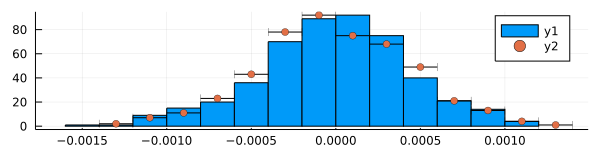

In [11]:
using Random, Distributions
using StatsBase
df = DataFrame(data)

lower = quantile(df[:,:Diff], 0.01)
upper = quantile(df[:,:Diff], 0.99)
df = filter(:Diff => x -> x > lower, df)
df = filter(:Diff => x -> x < upper, df)
@show mean(df[!,:Diff])
@show std(df[!,:Diff])
histogram(df[!,:Diff])
d=fit(Normal, df[!,:Diff])
n = length(df[:,:Diff])
plot!(rand(d, n), seriestype=:scatterhist, linestyle=:solid, size=(600,150))


In [12]:
@show mean(rand(d,10000))
@show std(rand(d,10000))

mean(rand(d, 10000)) = -1.0494189310594363e-5
std(rand(d, 10000)) = 0.00044227418010031995


0.00044227418010031995

In [13]:
@show mean(rand(d,10000))
@show std(rand(d,10000))

mean(rand(d, 10000)) = -5.193934885087355e-6
std(rand(d, 10000)) = 0.00044773754106430276


0.00044773754106430276

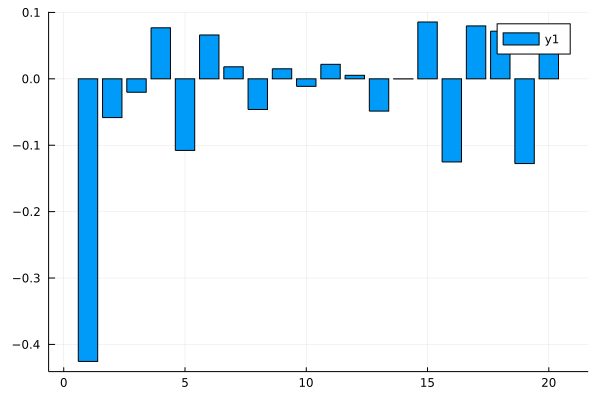

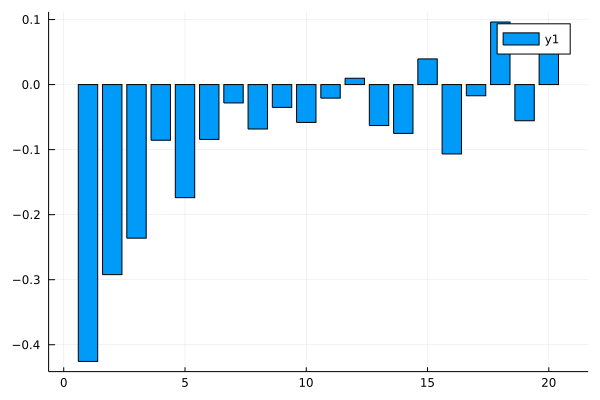

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.83729

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size in regression:          485
    number of lags:                     1
    ADF statistic:                      -25.0156
    Critical values at 1%, 5%, and 10%: [-2.57035 -1.94157 -1.61629]


In [14]:
testStationary(df[!,:Diff])

In [15]:
# Import Turing and Distributions.
using Turing, Distributions



# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

# Functionality for splitting and normalizing the data
using MLDataUtils: rescale!

# Set a seed for reproducibility.
using Random
Random.seed!(0);

In [16]:
# Bayesian logistic regression (LR)
@model linearPair(y0,y1,n) = begin
    u ~ Normal(1,0.1)
    for i = 1:n
        y1[i] ~ Normal( u*y0[i],0.1)
    end
end;

In [17]:

n,_ = size(df)
@show n
train = Matrix(df)


n = 487


487×4 Matrix{Any}:
 2019-06-21T04:00:00   0.00671149    0.00714554   -0.000434048
 2019-06-24T04:00:00   0.0146967     0.0141898     0.000506943
 2019-06-25T04:00:00   0.00194118    0.002209     -0.000267822
 2019-06-26T04:00:00  -0.00916546   -0.00955187    0.000386403
 2019-06-27T04:00:00  -0.000977515   0.0          -0.000977515
 2019-06-28T04:00:00   0.00248406    0.00185471    0.000629357
 2019-07-01T04:00:00  -0.0192983    -0.018882     -0.000416283
 2019-07-02T04:00:00   0.0212862     0.0211321     0.000154119
 2019-07-03T04:00:00   0.0019493     0.00221736   -0.000268063
 2019-07-05T04:00:00  -0.0110747    -0.0117995     0.000724752
 2019-07-08T04:00:00  -0.00658291   -0.00597023   -0.000612681
 2019-07-09T04:00:00   0.00373248    0.0033786     0.000353875
 2019-07-10T04:00:00   0.0154804     0.0153385     0.000141866
 ⋮                                                            
 2021-05-27T04:00:00   0.000844358   0.000691892   0.000152467
 2021-05-28T04:00:00   0.00298133   

In [18]:



# Sample using HMC.
chain = mapreduce(c -> sample(linearPair(train[:,2],train[:,3],n),NUTS(200, 0.65), 1000, discard_adapt=true),
    chainscat,
    1:5
)

describe(chain)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|███████

2-element Vector{ChainDataFrame}:
 Summary Statistics (1 x 8)
 Quantiles (1 x 6)

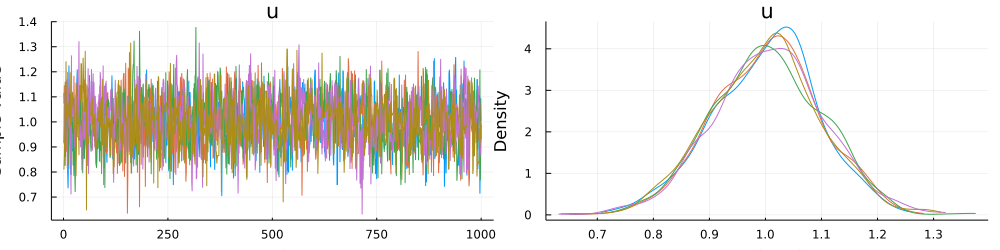

In [19]:
plot(chain)

In [20]:
chain

Chains MCMC chain (1000×13×5 Array{Float64, 3}):

Start time        = 2021-06-15T07:25:02.906
Stop time         = 2021-06-15T07:25:13.112
Wall duration     = 10.21 seconds
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5
Samples per chain = 1000
parameters        = u
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           u    1.0024    0.0971     0.0014    0.0023   2395.2100    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         

In [21]:
lookback = 12
for (row_index,row) in enumerate(eachrow(pct))
    @show row.timestamp
    @show row.Close1
    @show row.Close2
    @show row_index
    if row_index >= lookback
        i = row_index
        @show size(pct[i-lookback+1:i])
        @show pct[i-lookback+1:i]
        @show values(mean(pct[i-lookback+1:i]))
        
    end
    
end

row.timestamp = DateTime("2019-06-21T04:00:00")
row.Close1 = 0.0067114932f0
row.Close2 = 0.007145541f0
row_index = 1
row.timestamp = DateTime("2019-06-24T04:00:00")
row.Close1 = 0.014696737f0
row.Close2 = 0.014189794f0
row_index = 2
row.timestamp = DateTime("2019-06-25T04:00:00")
row.Close1 = 0.0019411783f0
row.Close2 = 0.0022090003f0
row_index = 3
row.timestamp = DateTime("2019-06-26T04:00:00")
row.Close1 = -0.009165464f0
row.Close2 = -0.009551867f0
row_index = 4
row.timestamp = DateTime("2019-06-27T04:00:00")
row.Close1 = -0.0009775149f0
row.Close2 = 0.0f0
row_index = 5
row.timestamp = DateTime("2019-06-28T04:00:00")
row.Close1 = 0.0024840639f0
row.Close2 = 0.001854707f0
row_index = 6
row.timestamp = DateTime("2019-07-01T04:00:00")
row.Close1 = -0.019298261f0
row.Close2 = -0.018881978f0
row_index = 7
row.timestamp = DateTime("2019-07-02T04:00:00")
row.Close1 = 0.021286238f0
row.Close2 = 0.021132119f0
row_index = 8
row.timestamp = DateTime("2019-07-03T04:00:00")
row.Close1 = 0.0019493

values(mean(pct[(i - lookback) + 1:i])) = Float32[0.005862421 0.005811986]
row.timestamp = DateTime("2019-08-19T04:00:00")
row.Close1 = -0.012000454f0
row.Close2 = -0.011740363f0
row_index = 41
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-02T04:00:00 to 2019-08-19T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0028478624 0.0028818746]
row.timestamp = DateTime("2019-08-20T04:00:00")
row.Close1 = 0.00796469f0
row.Close2 = 0.008036308f0
row_index = 42
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-05T04:00:00 to 2019-08-20T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0038353642 0.0038528393]
row.timestamp = DateTime("2019-08-21T04:00:00")
row.Close1 = -0.0032343897f0
row.Close2 = -0.0038126558f0
row_index = 43
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeAr

row.Close1 = -0.005360015f0
row.Close2 = -0.0055594305f0
row_index = 69
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-12T04:00:00 to 2019-09-27T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[4.469743f-5 3.341434f-5]
row.timestamp = DateTime("2019-09-30T04:00:00")
row.Close1 = -0.015314358f0
row.Close2 = -0.015373753f0
row_index = 70
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-13T04:00:00 to 2019-09-30T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0014146864 -0.0013642008]
row.timestamp = DateTime("2019-10-01T04:00:00")
row.Close1 = 0.005328017f0
row.Close2 = 0.005677784f0
row_index = 71
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-16T04:00:00 to 2019-10-01T04:00:00
values(mean(pct[(i - lookback) + 1:i]

row.Close1 = 0.0040742676f0
row.Close2 = 0.004580945f0
row_index = 97
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-22T04:00:00 to 2019-11-06T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.00042177128 0.00040501854]
row.timestamp = DateTime("2019-11-07T05:00:00")
row.Close1 = -0.015590406f0
row.Close2 = -0.015082616f0
row_index = 98
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-23T04:00:00 to 2019-11-07T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0011099329 -0.0010867807]
row.timestamp = DateTime("2019-11-08T05:00:00")
row.Close1 = -0.006436525f0
row.Close2 = -0.0064102304f0
row_index = 99
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-24T04:00:00 to 2019-11-08T05:00:00
values(mean(pct[(i - lookback) +

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-12-10T05:00:00 to 2019-12-26T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0028752265 0.002827622]
row.timestamp = DateTime("2019-12-27T05:00:00")
row.Close1 = -0.00056203303f0
row.Close2 = -0.00069188967f0
row_index = 132
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-12-11T05:00:00 to 2019-12-27T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0026042943 0.0025909985]
row.timestamp = DateTime("2019-12-30T05:00:00")
row.Close1 = 0.002388942f0
row.Close2 = 0.002077589f0
row_index = 133
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-12-12T05:00:00 to 2019-12-30T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0022174753 0.0021093783]
row.timestamp = DateTime("2019-12-31T05:00:00")
row.Close1 = 0.001892

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-22T05:00:00 to 2020-02-06T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.00040550795 0.00041071602]
row.timestamp = DateTime("2020-02-07T05:00:00")
row.Close1 = 0.0024419988f0
row.Close2 = 0.0023387559f0
row_index = 160
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-23T05:00:00 to 2020-02-07T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0005862755 0.0005776531]
row.timestamp = DateTime("2020-02-10T05:00:00")
row.Close1 = 0.0025715458f0
row.Close2 = 0.0026666848f0
row_index = 161
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-24T05:00:00 to 2020-02-10T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.00060754665 0.00063207996]
row.timestamp = DateTime("2020-02-11T05:00:00")
row.Close1 = -0.00

values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0046697673 -0.004712686]
row.timestamp = DateTime("2020-03-19T04:00:00")
row.Close1 = -0.018622296f0
row.Close2 = -0.018207364f0
row_index = 188
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-04T05:00:00 to 2020-03-19T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0088692475 -0.00881523]
row.timestamp = DateTime("2020-03-20T04:00:00")
row.Close1 = 0.014629968f0
row.Close2 = 0.01426548f0
row_index = 189
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-05T05:00:00 to 2020-03-20T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0077854167 -0.007839839]
row.timestamp = DateTime("2020-03-23T04:00:00")
row.Close1 = 0.044328466f0
row.Close2 = 0.043600433f0
row_index = 190
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 Tim

row.timestamp = DateTime("2020-05-11T04:00:00")
row.Close1 = -0.006169758f0
row.Close2 = -0.005521495f0
row_index = 224
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-04-24T04:00:00 to 2020-05-11T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0018387489 -0.0017881035]
row.timestamp = DateTime("2020-05-12T04:00:00")
row.Close1 = 0.004044584f0
row.Close2 = 0.0037013674f0
row_index = 225
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-04-27T04:00:00 to 2020-05-12T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.001287122 -0.0012282067]
row.timestamp = DateTime("2020-05-13T04:00:00")
row.Close1 = 0.0088374205f0
row.Close2 = 0.007990165f0
row_index = 226
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-04-28T04:00:00 to 2020

row.Close1 = 0.011377195f0
row.Close2 = 0.012150798f0
row_index = 252
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-04T04:00:00 to 2020-06-19T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0023407314 0.0022810297]
row.timestamp = DateTime("2020-06-22T04:00:00")
row.Close1 = 0.0064931f0
row.Close2 = 0.0060022483f0
row_index = 253
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-05T04:00:00 to 2020-06-22T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0019827392 0.0019591947]
row.timestamp = DateTime("2020-06-23T04:00:00")
row.Close1 = 0.008299268f0
row.Close2 = 0.008872538f0
row_index = 254
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-08T04:00:00 to 2020-06-23T04:00:00
values(mean(pct[(i - lookback) + 1:i])) 

row_index = 280
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-07-15T04:00:00 to 2020-07-30T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0064553353 0.006407595]
row.timestamp = DateTime("2020-07-31T04:00:00")
row.Close1 = 0.009305592f0
row.Close2 = 0.010182133f0
row_index = 281
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-07-16T04:00:00 to 2020-07-31T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0071377656 0.007159729]
row.timestamp = DateTime("2020-08-03T04:00:00")
row.Close1 = 0.0010782329f0
row.Close2 = 0.0005306221f0
row_index = 282
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-07-17T04:00:00 to 2020-08-03T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.008039624 0.008022348]
row.timestamp = Da

row_index = 318
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-09-10T04:00:00 to 2020-09-25T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0037195564 -0.0037605779]
row.timestamp = DateTime("2020-09-28T04:00:00")
row.Close1 = 0.009946371f0
row.Close2 = 0.010129388f0
row_index = 319
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-09-11T04:00:00 to 2020-09-28T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0026174763 -0.0026028575]
row.timestamp = DateTime("2020-09-29T04:00:00")
row.Close1 = 0.008659928f0
row.Close2 = 0.00891367f0
row_index = 320
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-09-14T04:00:00 to 2020-09-29T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0018958155 -0.0019050256]
row.timesta

row_index = 346
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-20T04:00:00 to 2020-11-04T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.00022678329 0.00020963314]
row.timestamp = DateTime("2020-11-05T05:00:00")
row.Close1 = 0.022985287f0
row.Close2 = 0.022552215f0
row_index = 347
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-21T04:00:00 to 2020-11-05T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0017358052 0.0017444347]
row.timestamp = DateTime("2020-11-06T05:00:00")
row.Close1 = 0.0015857859f0
row.Close2 = 0.0016137256f0
row_index = 348
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-22T04:00:00 to 2020-11-06T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0012170858 0.0012384149]
row.timestam

size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-11-30T05:00:00 to 2020-12-15T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0030768206 0.00308179]
row.timestamp = DateTime("2020-12-16T05:00:00")
row.Close1 = 0.0053462335f0
row.Close2 = 0.005655965f0
row_index = 375
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-12-01T05:00:00 to 2020-12-16T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0040617962 0.0040907413]
row.timestamp = DateTime("2020-12-17T05:00:00")
row.Close1 = 0.01057792f0
row.Close2 = 0.01012385f0
row_index = 376
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-12-02T05:00:00 to 2020-12-17T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0031854243 0.0031634634]
row.timestamp = DateTime("2020-12-1

size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-27T05:00:00 to 2021-02-11T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0011121049 -0.0011210088]
row.timestamp = DateTime("2021-02-12T05:00:00")
row.Close1 = -0.0029781729f0
row.Close2 = -0.0025861145f0
row_index = 414
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-28T05:00:00 to 2021-02-12T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.0008419142 -0.0008406387]
row.timestamp = DateTime("2021-02-16T05:00:00")
row.Close1 = -0.014352282f0
row.Close2 = -0.014117022f0
row_index = 415
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-29T05:00:00 to 2021-02-16T05:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[-0.002115221 -0.0020645557]
row.timestamp = DateT

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-03-09T05:00:00 to 2021-03-24T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.002565501 0.0025901415]
row.timestamp = DateTime("2021-03-25T04:00:00")
row.Close1 = -0.003387423f0
row.Close2 = -0.0036340326f0
row_index = 442
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-03-10T05:00:00 to 2021-03-25T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0005158962 0.0005175918]
row.timestamp = DateTime("2021-03-26T04:00:00")
row.Close1 = 0.0028426442f0
row.Close2 = 0.00303944f0
row_index = 443
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-03-11T05:00:00 to 2021-03-26T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.00032272254 0.00031215476]
row.timestamp = DateTime("2021-03-29T04:00:00")
row.Close1 = -0.012016

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-19T04:00:00 to 2021-05-04T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0001140247 0.000118036485]
row.timestamp = DateTime("2021-05-05T04:00:00")
row.Close1 = 0.0045028673f0
row.Close2 = 0.004722506f0
row_index = 470
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-20T04:00:00 to 2021-05-05T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0007246867 0.0007578383]
row.timestamp = DateTime("2021-05-06T04:00:00")
row.Close1 = 0.016436683f0
row.Close2 = 0.015869528f0
row_index = 471
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-21T04:00:00 to 2021-05-06T04:00:00
values(mean(pct[(i - lookback) + 1:i])) = Float32[0.0017980468 0.0017345123]
row.timestamp = DateTime("2021-05-07T04:00:00")
row.Close1 = 0.00905584

In [22]:
N = length(pct)
mean1,mean2 = values(mean(pct[1:lookback-1]))
@show mean1
@show mean2
std1,std2 = values(std(pct[1:lookback-1]))
@show std1
@show std2
function betafunc(x1,x2,beta)
    return x1 + beta*x2
end
std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1]
bf12 = betafunc.(pct[1:lookback-1,:Close1] , pct[1:lookback-1,:Close2],-1)
@show bf12
@show std12
currentprice = values(pct[12,:Close1])
@show currentprice
bf12

mean1 = 0.00017910107f0
mean2 = 0.00023135894f0
std1 = 0.011622808f0
std2 = 0.011551027f0
bf12 = 11×1 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-21T04:00:00 to 2019-07-08T04:00:00
std12 = 0.00056192133f0
currentprice = Float32[0.003732477]


11×1 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-21T04:00:00 to 2019-07-08T04:00:00
│                     │ Close1_Close2 │
├─────────────────────┼───────────────┤
│ 2019-06-21T04:00:00 │ -0.0004       │
│ 2019-06-24T04:00:00 │ 0.0005        │
│ 2019-06-25T04:00:00 │ -0.0003       │
│ 2019-06-26T04:00:00 │ 0.0004        │
│ 2019-06-27T04:00:00 │ -0.001        │
│ 2019-06-28T04:00:00 │ 0.0006        │
│ 2019-07-01T04:00:00 │ -0.0004       │
│ 2019-07-02T04:00:00 │ 0.0002        │
│ 2019-07-03T04:00:00 │ -0.0003       │
│ 2019-07-05T04:00:00 │ 0.0007        │
│ 2019-07-08T04:00:00 │ -0.0006       │

In [23]:
for i in 2:N
    @show values(pct[i-1:i,:Close1])
end

values(pct[i - 1:i, :Close1]) = Float32[0.0067114932; 0.014696737]
values(pct[i - 1:i, :Close1]) = Float32[0.014696737; 0.0019411783]
values(pct[i - 1:i, :Close1]) = Float32[0.0019411783; -0.009165464]
values(pct[i - 1:i, :Close1]) = Float32[-0.009165464; -0.0009775149]
values(pct[i - 1:i, :Close1]) = Float32[-0.0009775149; 0.0024840639]
values(pct[i - 1:i, :Close1]) = Float32[0.0024840639; -0.019298261]
values(pct[i - 1:i, :Close1]) = Float32[-0.019298261; 0.021286238]
values(pct[i - 1:i, :Close1]) = Float32[0.021286238; 0.0019493004]
values(pct[i - 1:i, :Close1]) = Float32[0.0019493004; -0.01107475]
values(pct[i - 1:i, :Close1]) = Float32[-0.01107475; -0.006582909]
values(pct[i - 1:i, :Close1]) = Float32[-0.006582909; 0.003732477]
values(pct[i - 1:i, :Close1]) = Float32[0.003732477; 0.015480384]
values(pct[i - 1:i, :Close1]) = Float32[0.015480384; -0.008369511]
values(pct[i - 1:i, :Close1]) = Float32[-0.008369511; 0.0060286317]
values(pct[i - 1:i, :Close1]) = Float32[0.0060286317; 7.

values(pct[i - 1:i, :Close1]) = Float32[-0.0087255; 0.005281518]
values(pct[i - 1:i, :Close1]) = Float32[0.005281518; -0.0001349358]
values(pct[i - 1:i, :Close1]) = Float32[-0.0001349358; 0.0061975047]
values(pct[i - 1:i, :Close1]) = Float32[0.0061975047; -0.006694695]
values(pct[i - 1:i, :Close1]) = Float32[-0.006694695; -0.013210006]
values(pct[i - 1:i, :Close1]) = Float32[-0.013210006; 0.0010925535]
values(pct[i - 1:i, :Close1]) = Float32[0.0010925535; 0.0057312544]
values(pct[i - 1:i, :Close1]) = Float32[0.0057312544; 0.0024419988]
values(pct[i - 1:i, :Close1]) = Float32[0.0024419988; 0.0025715458]
values(pct[i - 1:i, :Close1]) = Float32[0.0025715458; -0.0032400931]
values(pct[i - 1:i, :Close1]) = Float32[-0.0032400931; -0.0009479795]
values(pct[i - 1:i, :Close1]) = Float32[-0.0009479795; 0.0056938487]
values(pct[i - 1:i, :Close1]) = Float32[0.0056938487; 0.0041111344]
values(pct[i - 1:i, :Close1]) = Float32[0.0041111344; 0.0127535425]
values(pct[i - 1:i, :Close1]) = Float32[0.0127

values(pct[i - 1:i, :Close1]) = Float32[-0.0019264715; 0.009375861]
values(pct[i - 1:i, :Close1]) = Float32[0.009375861; -0.0032785912]
values(pct[i - 1:i, :Close1]) = Float32[-0.0032785912; 0.0]
values(pct[i - 1:i, :Close1]) = Float32[0.0; 0.00789404]
values(pct[i - 1:i, :Close1]) = Float32[0.00789404; -0.0021211032]
values(pct[i - 1:i, :Close1]) = Float32[-0.0021211032; 0.0026160066]
values(pct[i - 1:i, :Close1]) = Float32[0.0026160066; -0.0053277635]
values(pct[i - 1:i, :Close1]) = Float32[-0.0053277635; 0.0010935082]
values(pct[i - 1:i, :Close1]) = Float32[0.0010935082; -0.020090584]
values(pct[i - 1:i, :Close1]) = Float32[-0.020090584; -0.004791664]
values(pct[i - 1:i, :Close1]) = Float32[-0.004791664; -0.021496952]
values(pct[i - 1:i, :Close1]) = Float32[-0.021496952; 0.0036616444]
values(pct[i - 1:i, :Close1]) = Float32[0.0036616444; -0.0027932185]
values(pct[i - 1:i, :Close1]) = Float32[-0.0027932185; 0.009946371]
values(pct[i - 1:i, :Close1]) = Float32[0.009946371; 0.008659928

values(pct[i - 1:i, :Close1]) = Float32[0.016039811; 0.0062905885]
values(pct[i - 1:i, :Close1]) = Float32[0.0062905885; -0.0028250767]
values(pct[i - 1:i, :Close1]) = Float32[-0.0028250767; 0.0035563617]
values(pct[i - 1:i, :Close1]) = Float32[0.0035563617; 0.009850542]
values(pct[i - 1:i, :Close1]) = Float32[0.009850542; -0.006423733]
values(pct[i - 1:i, :Close1]) = Float32[-0.006423733; -0.0039508766]
values(pct[i - 1:i, :Close1]) = Float32[-0.0039508766; 0.0027044562]
values(pct[i - 1:i, :Close1]) = Float32[0.0027044562; -0.0025173873]
values(pct[i - 1:i, :Close1]) = Float32[-0.0025173873; 0.0030645502]
values(pct[i - 1:i, :Close1]) = Float32[0.0030645502; -0.0040140436]
values(pct[i - 1:i, :Close1]) = Float32[-0.0040140436; -0.0035485101]
values(pct[i - 1:i, :Close1]) = Float32[-0.0035485101; 0.013098405]
values(pct[i - 1:i, :Close1]) = Float32[0.013098405; -0.007626391]
values(pct[i - 1:i, :Close1]) = Float32[-0.007626391; 0.0045028673]
values(pct[i - 1:i, :Close1]) = Float32[0.0

In [24]:

function BuyOrSell(pct)
    lookback,_ = size(pct)
    df = DataFrame(pct[1:lookback-1])
    current = DataFrame(data[lookback])
    
    mean1,mean2 = values(mean(pct[1:lookback-1]))
    @show mean1
    @show mean2
    std1,std2 = values(std(pct[1:lookback-1]))
    @show std1
    @show std2
    mean12 = 0
    std12 = values(std(pct[1:lookback-1,:Close1] .- pct[1:lookback-1,:Close2]))[1] 
    @show std12
    p1 = values(pct[lookback,:Close1])[1]
    p2 = values(pct[lookback,:Close2])[1]
    dif12 = values(pct[lookback,:Close1] .- pct[lookback,:Close2])[1]
    @show p1
    @show p2
    @show dif12

    act1 = 0
    act2 = 0
    thd2 = 2
    thd1 = 1
    
    if p1 >= mean1 + thd2*std1
        act1 = -1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
                if dif12 > mean12 + thd1*std12
                    act2 = 1
                elseif dif12 < mean12 - thd1*std12
                    act2 = -1
                end    
        else
            act2 = 1
        end
    elseif p1 > mean1 - thd2*std1
        if p2 >= mean2 + thd2*std2
            act2 = -1
            if dif12 > mean12 + thd1*std12
                    act1 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = -1
            end  
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act1 = -1
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
                    act2 = -1
            end        
        else
            act2 = 1
            if dif12 > mean12 + thd1*std12
                    act1 = -1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
            end     
        end
    else
        act1 = 1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act2 = -1
            end       
        else
            act2 = 1
        end
    end
    return (act1,act2)
end

BuyOrSell (generic function with 1 method)

In [94]:
lookback = 12
timestampRows = DateTime[]
signal1 = Float32[]
signal2 = Float32[]
for (row_index,row) in enumerate(eachrow(pct))
    @show row.timestamp
    @show row.Close1
    @show row.Close2
    @show row_index
    if row_index >= lookback
        i = row_index
        @show size(pct[i-lookback+1:i])
        @show pct[i-lookback+1:i]
        buy1,buy2 =  BuyOrSell(pct[i-lookback+1:i])
        @show buy1
        @show buy2
        append!(timestampRows, [row.timestamp])
        append!(signal1, [buy1])
        append!(signal2, [buy2])
    end
    
end
resultTab = (datetime = timestampRows,
        Signal1 = signal1, Signal2 = signal2
    )
        
@show resultTab
resultTA = TimeArray(resultTab; timestamp = :datetime, meta = "result")

row.timestamp = DateTime("2019-06-21T04:00:00")
row.Close1 = 0.0067114932f0
row.Close2 = 0.007145541f0
row_index = 1
row.timestamp = DateTime("2019-06-24T04:00:00")
row.Close1 = 0.014696737f0
row.Close2 = 0.014189794f0
row_index = 2
row.timestamp = DateTime("2019-06-25T04:00:00")
row.Close1 = 0.0019411783f0
row.Close2 = 0.0022090003f0
row_index = 3
row.timestamp = DateTime("2019-06-26T04:00:00")
row.Close1 = -0.009165464f0
row.Close2 = -0.009551867f0
row_index = 4
row.timestamp = DateTime("2019-06-27T04:00:00")
row.Close1 = -0.0009775149f0
row.Close2 = 0.0f0
row_index = 5
row.timestamp = DateTime("2019-06-28T04:00:00")
row.Close1 = 0.0024840639f0
row.Close2 = 0.001854707f0
row_index = 6
row.timestamp = DateTime("2019-07-01T04:00:00")
row.Close1 = -0.019298261f0
row.Close2 = -0.018881978f0
row_index = 7
row.timestamp = DateTime("2019-07-02T04:00:00")
row.Close1 = 0.021286238f0
row.Close2 = 0.021132119f0
row_index = 8
row.timestamp = DateTime("2019-07-03T04:00:00")
row.Close1 = 0.0019493

row_index = 47
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-12T04:00:00 to 2019-08-27T04:00:00
mean1 = 0.0018793981f0
mean2 = 0.001796947f0
std1 = 0.009052997f0
std2 = 0.009093572f0
std12 = 0.00034119913f0
p1 = 0.009154484f0
p2 = 0.0092338845f0
dif12 = -7.940084f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-08-28T04:00:00")
row.Close1 = -0.0024051308f0
row.Close2 = -0.0016944342f0
row_index = 48
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-13T04:00:00 to 2019-08-28T04:00:00
mean1 = 0.0018688109f0
mean2 = 0.0018122359f0
std1 = 0.009043552f0
std2 = 0.009107146f0
std12 = 0.00034174894f0
p1 = -0.0024051308f0
p2 = -0.0016944342f0
dif12 = -0.00071069656f0
buy1 = 1
buy2 = -1
row.timestamp = DateTime("2019-08-29T04:00:00")
row.Close1 = -0.0070957914f0
row.Close2 = -0.007807137f0
row_index = 49
size(pct[(i - lookback)

mean1 = 0.0011002329f0
mean2 = 0.0010539918f0
std1 = 0.008841806f0
std2 = 0.008912256f0
std12 = 0.0007756081f0
p1 = -7.056941f-5
p2 = 0.0006954703f0
dif12 = -0.0007660397f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-09-27T04:00:00")
row.Close1 = -0.005360015f0
row.Close2 = -0.0055594305f0
row_index = 69
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-12T04:00:00 to 2019-09-27T04:00:00
mean1 = 0.00053603493f0
mean2 = 0.00054185477f0
std1 = 0.008684984f0
std2 = 0.008738999f0
std12 = 0.0008116807f0
p1 = -0.005360015f0
p2 = -0.0055594305f0
dif12 = 0.00019941526f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-09-30T04:00:00")
row.Close1 = -0.015314358f0
row.Close2 = -0.015373753f0
row_index = 70
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-09-13T04:00:00 to 2019-09-30T04:00:00
mean1 = -0.00015107998f0
mean2 = -9.0605

mean1 = -0.0027060767f0
mean2 = -0.0026851473f0
std1 = 0.0073300106f0
std2 = 0.007400778f0
std12 = 0.00042132236f0
p1 = 0.0031836536f0
p2 = 0.0032085283f0
dif12 = -2.4874695f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-11-19T05:00:00")
row.Close1 = 0.0005050981f0
row.Close2 = 0.0007107398f0
row_index = 106
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-11-04T05:00:00 to 2019-11-19T05:00:00
mean1 = -0.002518797f0
mean2 = -0.002487839f0
std1 = 0.0074627567f0
std2 = 0.007537635f0
std12 = 0.00041984743f0
p1 = 0.0005050981f0
p2 = 0.0007107398f0
dif12 = -0.00020564173f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-11-20T05:00:00")
row.Close1 = 0.0002885281f0
row.Close2 = 0.0f0
row_index = 107
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-11-05T05:00:00 to 2019-11-20T05:00:00
mean1 = -0.0021987222f0
mean2 = -0.002203259

p2 = -0.0003544656f0
dif12 = 0.00028246577f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-12-19T05:00:00")
row.Close1 = 0.002374125f0
row.Close2 = 0.0017725423f0
row_index = 127
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-12-04T05:00:00 to 2019-12-19T05:00:00
mean1 = -8.250898f-5
mean2 = -0.00015083754f0
std1 = 0.0044440306f0
std2 = 0.004720817f0
std12 = 0.00067149394f0
p1 = 0.002374125f0
p2 = 0.0017725423f0
dif12 = 0.0006015827f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2019-12-20T05:00:00")
row.Close1 = -0.0012199584f0
row.Close2 = -0.0007076143f0
row_index = 128
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-12-05T05:00:00 to 2019-12-20T05:00:00
mean1 = 0.00027054592f0
mean2 = 0.00023548068f0
std1 = 0.004473497f0
std2 = 0.0046851686f0
std12 = 0.0006302984f0
p1 = -0.0012199584f0
p2 = -0.0007076143f0
dif12 = -0.00

std12 = 0.00045672813f0
p1 = -0.0009479795f0
p2 = -0.0003337303f0
dif12 = -0.0006142492f0
buy1 = 1
buy2 = -1
row.timestamp = DateTime("2020-02-13T05:00:00")
row.Close1 = 0.0056938487f0
row.Close2 = 0.0056761056f0
row_index = 164
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-29T05:00:00 to 2020-02-13T05:00:00
mean1 = -8.284853f-5
mean2 = -7.5102755f-5
std1 = 0.005861599f0
std2 = 0.0059024543f0
std12 = 0.0004960854f0
p1 = 0.0056938487f0
p2 = 0.0056761056f0
dif12 = 1.7743092f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-02-14T05:00:00")
row.Close1 = 0.0041111344f0
row.Close2 = 0.0043158415f0
row_index = 165
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-30T05:00:00 to 2020-02-14T05:00:00
mean1 = -4.536392f-5
mean2 = 1.6378832f-5
std1 = 0.0059005236f0
std2 = 0.0059904912f0
std12 = 0.0004523116f0
p1 = 0.0041111344f0


row.Close2 = -0.010302039f0
row_index = 185
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-02-28T05:00:00 to 2020-03-16T04:00:00
mean1 = -0.006279835f0
mean2 = -0.0061876937f0
std1 = 0.02307093f0
std2 = 0.02281495f0
std12 = 0.0006691504f0
p1 = -0.009627429f0
p2 = -0.010302039f0
dif12 = 0.00067461f0
buy1 = -1
buy2 = 1
row.timestamp = DateTime("2020-03-17T04:00:00")
row.Close1 = 0.0133134f0
row.Close2 = 0.013185122f0
row_index = 186
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-02T05:00:00 to 2020-03-17T04:00:00
mean1 = -0.0038944033f0
mean2 = -0.003925259f0
std1 = 0.020966355f0
std2 = 0.0207961f0
std12 = 0.0006749433f0
p1 = 0.0133134f0
p2 = 0.013185122f0
dif12 = 0.00012827758f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-03-18T04:00:00")
row.Close1 = -0.021967158f0
row.Close2 = -0.021917721f0
row_index = 187
size(pct

row.Close2 = -0.0060974862f0
row_index = 223
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-04-23T04:00:00 to 2020-05-08T04:00:00
mean1 = 1.878359f-5
mean2 = 4.7968362f-5
std1 = 0.010146412f0
std2 = 0.01026306f0
std12 = 0.0005365447f0
p1 = -0.006070235f0
p2 = -0.0060974862f0
dif12 = 2.725143f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-05-11T04:00:00")
row.Close1 = -0.006169758f0
row.Close2 = -0.005521495f0
row_index = 224
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-04-24T04:00:00 to 2020-05-11T04:00:00
mean1 = -0.001445021f0
mean2 = -0.0014487043f0
std1 = 0.009709511f0
std2 = 0.009797808f0
std12 = 0.0005269732f0
p1 = -0.006169758f0
p2 = -0.005521495f0
dif12 = -0.0006482629f0
buy1 = 1
buy2 = -1
row.timestamp = DateTime("2020-05-12T04:00:00")
row.Close1 = 0.004044584f0
row.Close2 = 0.0037013674f0
row_index = 225
siz

mean1 = -0.001371814f0
mean2 = -0.0013858957f0
std1 = 0.01161157f0
std2 = 0.011331304f0
std12 = 0.0004258629f0
p1 = 0.009455279f0
p2 = 0.00924784f0
dif12 = 0.00020743906f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-06-10T04:00:00")
row.Close1 = 0.014577234f0
row.Close2 = 0.014660933f0
row_index = 245
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-05-26T04:00:00 to 2020-06-10T04:00:00
mean1 = -0.001061391f0
mean2 = -0.0010692579f0
std1 = 0.011872266f0
std2 = 0.01159666f0
std12 = 0.00042214428f0
p1 = 0.014577234f0
p2 = 0.014660933f0
dif12 = -8.369889f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-06-11T04:00:00")
row.Close1 = -0.007030926f0
row.Close2 = -0.0066224616f0
row_index = 246
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-05-27T04:00:00 to 2020-06-11T04:00:00
mean1 = 0.0015782636f0
mean2 = 0.0015524755f0
st

std1 = 0.0065949457f0
std2 = 0.006756422f0
std12 = 0.00038853355f0
p1 = 0.0010782329f0
p2 = 0.0005306221f0
dif12 = 0.0005476108f0
buy1 = -1
buy2 = 1
row.timestamp = DateTime("2020-08-04T04:00:00")
row.Close1 = 0.020843176f0
row.Close2 = 0.021150379f0
row_index = 283
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-07-20T04:00:00 to 2020-08-04T04:00:00
mean1 = 0.007989092f0
mean2 = 0.007982596f0
std1 = 0.0069818515f0
std2 = 0.0071938317f0
std12 = 0.00042438981f0
p1 = 0.020843176f0
p2 = 0.021150379f0
dif12 = -0.00030720234f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-08-05T04:00:00")
row.Close1 = 0.009549628f0
row.Close2 = 0.009403536f0
row_index = 284
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-07-21T04:00:00 to 2020-08-05T04:00:00
mean1 = 0.009467215f0
mean2 = 0.009458289f0
std1 = 0.007855321f0
std2 = 0.008108976f0
st

row.timestamp = DateTime("2020-09-04T04:00:00")
row.Close1 = 0.0029258532f0
row.Close2 = 0.003260911f0
row_index = 304
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-20T04:00:00 to 2020-09-04T04:00:00
mean1 = -0.0005125782f0
mean2 = -0.00054760504f0
std1 = 0.0096965665f0
std2 = 0.0097547555f0
std12 = 0.00035157384f0
p1 = 0.0029258532f0
p2 = 0.003260911f0
dif12 = -0.00033505773f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-09-08T04:00:00")
row.Close1 = -0.0019264715f0
row.Close2 = -0.0016251695f0
row_index = 305
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-21T04:00:00 to 2020-09-08T04:00:00
mean1 = -0.00083517184f0
mean2 = -0.0007911267f0
std1 = 0.009497866f0
std2 = 0.009608956f0
std12 = 0.000324734f0
p1 = -0.0019264715f0
p2 = -0.0016251695f0
dif12 = -0.00030130195f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("20

mean1 = -0.00073632674f0
mean2 = -0.0007009237f0
std1 = 0.006902676f0
std2 = 0.006654356f0
std12 = 0.0005225793f0
p1 = -0.01636321f0
p2 = -0.01648351f0
dif12 = 0.0001203008f0
buy1 = 1
buy2 = 1
row.timestamp = DateTime("2020-10-29T04:00:00")
row.Close1 = -0.004087654f0
row.Close2 = -0.0044691535f0
row_index = 342
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-14T04:00:00 to 2020-10-29T04:00:00
mean1 = -0.0007839251f0
mean2 = -0.0008366462f0
std1 = 0.0070180786f0
std2 = 0.006982107f0
std12 = 0.00044806956f0
p1 = -0.004087654f0
p2 = -0.0044691535f0
dif12 = 0.00038149953f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-10-30T04:00:00")
row.Close1 = 0.004503825f0
row.Close2 = 0.0044892165f0
row_index = 343
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-10-15T04:00:00 to 2020-10-30T04:00:00
mean1 = -0.0014471273f0
mean2 = -0.

p2 = -0.01044691f0
dif12 = 0.00018215366f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-11-30T05:00:00")
row.Close1 = -0.0064734784f0
row.Close2 = -0.0064514484f0
row_index = 363
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-11-12T05:00:00 to 2020-11-30T05:00:00
mean1 = -0.0037436797f0
mean2 = -0.0037447363f0
std1 = 0.008468273f0
std2 = 0.008592044f0
std12 = 0.00043808605f0
p1 = -0.0064734784f0
p2 = -0.0064514484f0
dif12 = -2.202997f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2020-12-01T05:00:00")
row.Close1 = 0.021094384f0
row.Close2 = 0.021251176f0
row_index = 364
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-11-13T05:00:00 to 2020-12-01T05:00:00
mean1 = -0.0048883474f0
mean2 = -0.004868257f0
std1 = 0.007828829f0
std2 = 0.007990695f0
std12 = 0.00043253935f0
p1 = 0.021094384f0
p2 = 0.021251176f0
dif12 = -0.00015679

mean1 = -0.0037728907f0
mean2 = -0.0038055384f0
std1 = 0.013495244f0
std2 = 0.01347873f0
std12 = 0.0003970703f0
p1 = -0.007817073f0
p2 = -0.0072991187f0
dif12 = -0.0005179541f0
buy1 = 1
buy2 = -1
row.timestamp = DateTime("2021-01-25T05:00:00")
row.Close1 = 0.00092024205f0
row.Close2 = 0.0011312203f0
row_index = 400
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-07T05:00:00 to 2021-01-25T05:00:00
mean1 = -0.0030070564f0
mean2 = -0.0030020208f0
std1 = 0.012944728f0
std2 = 0.0129219955f0
std12 = 0.00042961273f0
p1 = 0.00092024205f0
p2 = 0.0011312203f0
dif12 = -0.0002109782f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-01-26T05:00:00")
row.Close1 = -0.0025283268f0
row.Close2 = -0.003107478f0
row_index = 401
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-08T05:00:00 to 2021-01-26T05:00:00
mean1 = -0.002701074f0
mean2 =

std12 = 0.0005971029f0
p1 = -0.00206543f0
p2 = -0.0029002014f0
dif12 = 0.00083477143f0
buy1 = -1
buy2 = 1
row.timestamp = DateTime("2021-02-24T05:00:00")
row.Close1 = -0.00082792324f0
row.Close2 = -0.0005818104f0
row_index = 421
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-02-08T05:00:00 to 2021-02-24T05:00:00
mean1 = -0.0003342148f0
mean2 = -0.0002787431f0
std1 = 0.008881771f0
std2 = 0.009140614f0
std12 = 0.0006238447f0
p1 = -0.00082792324f0
p2 = -0.0005818104f0
dif12 = -0.00024611282f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-02-25T05:00:00")
row.Close1 = -0.018700441f0
row.Close2 = -0.01860311f0
row_index = 422
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-02-09T05:00:00 to 2021-02-25T05:00:00
mean1 = -0.0013142214f0
mean2 = -0.0013329622f0
std1 = 0.008202002f0
std2 = 0.008341676f0
std12 = 0.0005341891f0
p1 = -

buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-04-16T04:00:00")
row.Close1 = 0.0062905885f0
row.Close2 = 0.0065439744f0
row_index = 457
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-03-31T04:00:00 to 2021-04-16T04:00:00
mean1 = 0.004415532f0
mean2 = 0.004422721f0
std1 = 0.008871375f0
std2 = 0.008848134f0
std12 = 0.0005520999f0
p1 = 0.0062905885f0
p2 = 0.0065439744f0
dif12 = -0.00025338586f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-04-19T04:00:00")
row.Close1 = -0.0028250767f0
row.Close2 = -0.002955115f0
row_index = 458
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-01T04:00:00 to 2021-04-19T04:00:00
mean1 = 0.003579656f0
mean2 = 0.0035972232f0
std1 = 0.008125915f0
std2 = 0.008089622f0
std12 = 0.00055589015f0
p1 = -0.0028250767f0
p2 = -0.002955115f0
dif12 = 0.00013003824f0
buy1 = 0
buy2 = 0
row.timestamp = DateT

row_index = 478
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-30T04:00:00 to 2021-05-17T04:00:00
mean1 = 0.00348152f0
mean2 = 0.003518912f0
std1 = 0.008303573f0
std2 = 0.008420288f0
std12 = 0.00052491465f0
p1 = 0.0118137365f0
p2 = 0.01186681f0
dif12 = -5.307328f-5
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-05-18T04:00:00")
row.Close1 = 0.0016598157f0
row.Close2 = 0.0017718258f0
row_index = 479
size(pct[(i - lookback) + 1:i]) = (12, 2)
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-05-03T04:00:00 to 2021-05-18T04:00:00
mean1 = 0.0048780884f0
mean2 = 0.004953062f0
std1 = 0.008294838f0
std2 = 0.008371999f0
std12 = 0.0005081219f0
p1 = 0.0016598157f0
p2 = 0.0017718258f0
dif12 = -0.000112010166f0
buy1 = 0
buy2 = 0
row.timestamp = DateTime("2021-05-19T04:00:00")
row.Close1 = 0.0008572436f0
row.Close2 = 0.0004998502f0
row_index = 480
size(pct[(i - lookback) + 1:i]

resultTab = (datetime = [DateTime("2019-07-09T04:00:00"), DateTime("2019-07-10T04:00:00"), DateTime("2019-07-11T04:00:00"), DateTime("2019-07-12T04:00:00"), DateTime("2019-07-15T04:00:00"), DateTime("2019-07-16T04:00:00"), DateTime("2019-07-17T04:00:00"), DateTime("2019-07-18T04:00:00"), DateTime("2019-07-19T04:00:00"), DateTime("2019-07-22T04:00:00"), DateTime("2019-07-23T04:00:00"), DateTime("2019-07-24T04:00:00"), DateTime("2019-07-25T04:00:00"), DateTime("2019-07-26T04:00:00"), DateTime("2019-07-29T04:00:00"), DateTime("2019-07-30T04:00:00"), DateTime("2019-07-31T04:00:00"), DateTime("2019-08-01T04:00:00"), DateTime("2019-08-02T04:00:00"), DateTime("2019-08-05T04:00:00"), DateTime("2019-08-06T04:00:00"), DateTime("2019-08-07T04:00:00"), DateTime("2019-08-08T04:00:00"), DateTime("2019-08-09T04:00:00"), DateTime("2019-08-12T04:00:00"), DateTime("2019-08-13T04:00:00"), DateTime("2019-08-14T04:00:00"), DateTime("2019-08-15T04:00:00"), DateTime("2019-08-16T04:00:00"), DateTime("2019-08-

486×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-07-09T04:00:00 to 2021-06-14T04:00:00
│                     │ Signal1 │ Signal2 │
├─────────────────────┼─────────┼─────────┤
│ 2019-07-09T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-10T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-11T04:00:00 │ 1.0     │ -1.0    │
│ 2019-07-12T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-15T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-16T04:00:00 │ 1.0     │ -1.0    │
│ 2019-07-17T04:00:00 │ -1.0    │ 1.0     │
│ 2019-07-18T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-19T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-22T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-23T04:00:00 │ 0.0     │ 0.0     │
│ 2019-07-24T04:00:00 │ 0.0     │ 0.0     │
   ⋮
│ 2021-05-28T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-01T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-02T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-03T04:00:00 │ 1.0     │ 0.0     │
│ 2021-06-04T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-07T04:00:00 │ 0.0     │ 0.0     │
│ 2021-06-08T04:0

In [95]:
prices = merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])
PL = merge(prices,resultTA,colnames = [:Close1,:Close2,:Signal1,:Signal2])

486×4 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-07-09T04:00:00 to 2021-06-14T04:00:00
│                     │ Close1  │ Close2 │ Signal1 │ Signal2 │
├─────────────────────┼─────────┼────────┼─────────┼─────────┤
│ 2019-07-09T04:00:00 │ 131.78  │ 13.365 │ 0.0     │ 0.0     │
│ 2019-07-10T04:00:00 │ 133.82  │ 13.57  │ 0.0     │ 0.0     │
│ 2019-07-11T04:00:00 │ 132.7   │ 13.47  │ 1.0     │ -1.0    │
│ 2019-07-12T04:00:00 │ 133.5   │ 13.545 │ 0.0     │ 0.0     │
│ 2019-07-15T04:00:00 │ 133.51  │ 13.54  │ 0.0     │ 0.0     │
│ 2019-07-16T04:00:00 │ 132.385 │ 13.44  │ 1.0     │ -1.0    │
│ 2019-07-17T04:00:00 │ 134.59  │ 13.645 │ -1.0    │ 1.0     │
│ 2019-07-18T04:00:00 │ 136.43  │ 13.84  │ 0.0     │ 0.0     │
│ 2019-07-19T04:00:00 │ 134.47  │ 13.64  │ 0.0     │ 0.0     │
│ 2019-07-22T04:00:00 │ 134.46  │ 13.64  │ 0.0     │ 0.0     │
│ 2019-07-23T04:00:00 │ 133.69  │ 13.555 │ 0.0     │ 0.0     │
│ 2019-07-24T04:00:00 │ 134.37  │ 13.62  │ 0.0     │ 0.0     │
   ⋮
│ 2021-05-28T04

In [97]:
position = [0,0]
balance = [0.0,0.0]
N ,_ = size(PL)
PL1 = zeros(N)
PL2 = zeros(N)
for (row_index,row) in enumerate(eachrow(PL))
    if position[1] == 0 && row.Signal1 == 1 && row_index < N
        position[1] = 1
        balance[1] = balance[1] - row.Close1
        
    elseif position[1] == 1 && row.Signal1 == -1
        position[1] = 0
        balance[1] = balance[1] + row.Close1
        PL1[row_index] = balance[1]
    end
    
    if position[2] == 0 && row.Signal2 == 1 && row_index < N
        position[2] = 1
        balance[2] = balance[2] - row.Close2
    elseif position[2] == 1 && row.Signal2 == -1
        position[2] = 0
        balance[2] = balance[2] + row.Close2
        PL2[row_index] = balance[2]
    end
    if row_index == N
        if position[1] == 1 
            position[1] = 0
            balance[1] = balance[1] + row.Close1
            PL1[row_index] = balance[1]
        end
        if position[2] == 1 
            position[2] = 0
            balance[2] = balance[2] + row.Close2
            PL2[row_index] = balance[2]
        end
    end
end
    
@show balance
@show position

balance = [6.4166107177734375, 1.3222980499267578]
position = [0, 0]


2-element Vector{Int64}:
 0
 0

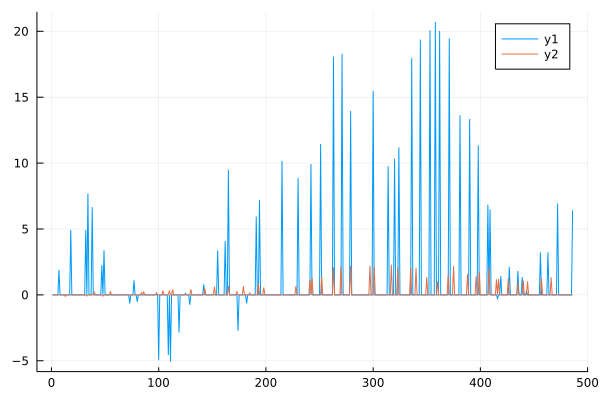

In [99]:
plot(PL1)
plot!(PL2)

In [105]:
@show count(y->y>0,PL1)
@show count(y->y<0,PL1)
@show count(y->y>0,PL2)
@show count(y->y<0,PL2)

count((y->begin
            #= In[105]:1 =#
            y > 0
        end), PL1) = 47
count((y->begin
            #= In[105]:2 =#
            y < 0
        end), PL1) = 10
count((y->begin
            #= In[105]:3 =#
            y > 0
        end), PL2) = 49
count((y->begin
            #= In[105]:4 =#
            y < 0
        end), PL2) = 4


4

In [108]:
function computeScore(PL)
    profit = count(y->y>0,PL)
    loss = count(y->y<0,PL)
    return profit / (profit+loss)
end
@show computeScore(PL1)
@show computeScore(PL2)

computeScore(PL1) = 0.8245614035087719
computeScore(PL2) = 0.9245283018867925


0.9245283018867925

In [80]:
length(signal1)

486